In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data/cifar10', train=False, download=True, transform=transform)

batch_size = 32

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1) # 疑问：out_channels如何填？out_channels=band数*kernel_size，即3*3*3=27
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1) # out_channels与in_channels保持一致
        self.act2 = nn.ReLU()

        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(8192, 512) # in_features：上一层的output。out_features：随便？
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(512, 10)

    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x

model = CIFAR10Model()
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

n_epochs = 20
for epoch in range(n_epochs):
    for inputs, labels in trainloader:
        # forward, backward, and then weight update
        y_pred = model(inputs.to(device)).to(device)
        loss = loss_fn(y_pred, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    acc = 0
    count = 0
    for inputs, labels in testloader:
        y_pred = model(inputs.to(device)).to(device)
        acc += (torch.argmax(y_pred, 1) == labels.to(device)).float().sum()
        count += len(labels)
    acc /= count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))

torch.save(model.state_dict(), "cifar10model.pth")


Epoch 0: model accuracy 35.31%
Epoch 1: model accuracy 42.36%
Epoch 2: model accuracy 46.65%
Epoch 3: model accuracy 49.56%
Epoch 4: model accuracy 51.64%
Epoch 5: model accuracy 53.23%
Epoch 6: model accuracy 53.48%
Epoch 7: model accuracy 55.85%
Epoch 8: model accuracy 56.65%
Epoch 9: model accuracy 58.27%
Epoch 10: model accuracy 59.21%
Epoch 11: model accuracy 59.45%
Epoch 12: model accuracy 60.87%
Epoch 13: model accuracy 60.20%
Epoch 14: model accuracy 60.90%
Epoch 15: model accuracy 62.00%
Epoch 16: model accuracy 61.35%
Epoch 17: model accuracy 62.15%
Epoch 18: model accuracy 62.66%
Epoch 19: model accuracy 62.65%


# CPU：2min30s完成两轮；GPU：20s完成2轮，3m24.7s完成20轮。

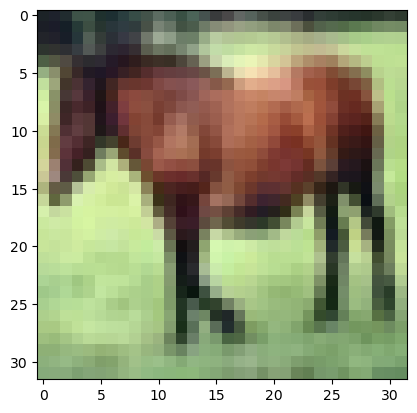

In [5]:
import matplotlib.pyplot as plt

plt.imshow(trainset.data[7])
plt.show()

In [8]:
X = torch.tensor([trainset.data[7]], dtype=torch.float32).permute(0,3,1,2).to(device)
model.eval()
with torch.no_grad():
    feature_maps = model.conv1(X)

# 问题：你咋训练自己的模型？
你没有那么多单张描述某个物体的图，一张遥感影像中同时存在许多不同的物体。
答：在obia中每张图片分成了很多segment，有部分segment有land cover。所有有landcover的segment，可以划分为训练集和测试集。然后预测所有segment对应的分类。

确认这个是否正确：在obia中每张图片分成了很多segment。如何获得已分类的segment以及它的land cover。但是每个segment不是固定的shape